In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from utils import *
from models import *
from tqdm import tqdm

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dmin = 2
dmax = 5
m = 8
t = 100
n = 10000
lamda = 0.2
radius = 0.1
mc_range = 3

SNRs = [-10.0, -5.0, 0.0, 5.0, 10.0, 15.0, 20.0]

array = UCA(m=m, lamda=lamda)
array.build_sensor_positions(radius=radius)
array.build_array_manifold()

torch.manual_seed(30)
mc_coef = torch.zeros(5, dtype=torch.complex64)
mc_coef[:mc_range] = torch.rand(mc_range, dtype=torch.complex64)
C = build_symmetric_circulant_toeplitz(mc_coef) 
C = C - torch.diag(torch.diag(C)) + torch.eye(m, dtype=torch.complex64)
torch.manual_seed(torch.seed())

methods = []
accuracy = {}

In [4]:
methods.append("DA-MUSIC")
accuracy["DA-MUSIC"] = []

for snr in SNRs:

    observations, angles, labels = generate_data(n, t, dmin, dmax, snr, snr, array, False, C)
    test_set = DATASET(observations, angles, labels)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    model = DA_MUSIC(dmin, dmax, array).to(dev)
    model.load_state_dict(torch.load("saved_models/damusic_{}dB.pth".format(snr), weights_only=True))
    loss_func_test_global = RMSPE_varied_nbSources(dmin, dmax, dev)

    running_acc_d = 0.0
    running_loss_theta = 0.0

    for data in test_loader:

        X, theta_true, label_true = data[0].to(dev), data[1].to(dev), data[2].to(dev)
        theta_pred, label_pred = model(X)
        # loss_theta = loss_func_test_global.calculate(theta_pred, theta_true)
        # running_loss_theta += loss_theta.item()
        acc_d = (torch.argmax(label_pred, dim=1) == torch.argmax(label_true, dim=1)).float().mean()
        running_acc_d += acc_d.item()

    acc = running_acc_d / len(test_loader)
    accuracy["DA-MUSIC"].append(acc)

In [5]:
methods.append("DA-MUSIC v2")
accuracy["DA-MUSIC v2"] = []

for snr in SNRs:

    observations, angles, labels = generate_data(n, t, dmin, dmax, snr, snr, array, False, C)
    test_set = DATASET(observations, angles, labels)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    model = DA_MUSIC_v2(dmin, dmax, array).to(dev)
    model.load_state_dict(torch.load("saved_models/damusic_v2_{}dB.pth".format(snr), weights_only=True))
    loss_func_test_global = RMSPE_varied_nbSources(dmin, dmax, dev)

    running_acc_d = 0.0
    running_loss_theta = 0.0

    for data in test_loader:

        X, theta_true, label_true = data[0].to(dev), data[1].to(dev), data[2].to(dev)
        theta_pred, label_pred = model(X)
        # loss_theta = loss_func_test_global.calculate(theta_pred, theta_true)
        # running_loss_theta += loss_theta.item()
        acc_d = (torch.argmax(label_pred, dim=1) == torch.argmax(label_true, dim=1)).float().mean()
        running_acc_d += acc_d.item()

    acc = running_acc_d / len(test_loader)
    accuracy["DA-MUSIC v2"].append(acc)

In [6]:
methods.append("RNN")
accuracy["RNN"] = []

for snr in SNRs:

    observations, angles, labels = generate_data(n, t, dmin, dmax, snr, snr, array, False, C)
    test_set = DATASET(observations, angles, labels)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    model = RNN(m, dmin, dmax).to(dev)
    model.load_state_dict(torch.load("saved_models/rnn_{}dB.pth".format(snr), weights_only=True))
    loss_func_test_global = RMSPE_varied_nbSources(dmin, dmax, dev)

    running_acc_d = 0.0
    running_loss_theta = 0.0

    for data in test_loader:

        X, theta_true, label_true = data[0].to(dev), data[1].to(dev), data[2].to(dev)
        theta_pred, label_pred = model(X)
        # loss_theta = loss_func_test_global.calculate(theta_pred, theta_true)
        # running_loss_theta += loss_theta.item()
        acc_d = (torch.argmax(label_pred, dim=1) == torch.argmax(label_true, dim=1)).float().mean()
        running_acc_d += acc_d.item()

    acc = running_acc_d / len(test_loader)
    accuracy["RNN"].append(acc)

In [7]:
methods.append("ECNet")
accuracy["ECNet"] = []

for snr in SNRs:

    observations, angles, labels = generate_data(n, t, dmin, dmax, snr, snr, array, False, C)
    test_set = DATASET(observations, angles, labels)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    model = ECNet(m=m, dmin=dmin, dmax=dmax, nbLayers=10, nbNeurons=10, device=dev)
    model.load_state_dict(torch.load("saved_models/ecnet_{}dB.pth".format(snr), weights_only=True))

    running_acc = 0.0

    for data in test_loader:

        X, theta_true, label_true = data[0].to(dev), data[1].to(dev), data[2].to(dev)
        label_pred = model(X)
        acc = (torch.argmax(label_pred, dim=1) == torch.argmax(label_true, dim=1)).float().mean()
        running_acc += acc.item()

    acc = running_acc / len(test_loader)
    accuracy["ECNet"].append(acc)

In [8]:
methods.append("AIC")
accuracy["AIC"] = []

for snr in SNRs:

    observations, angles, labels = generate_data(n, t, dmin, dmax, snr, snr, array, False, C)
    nbSources_test = torch.argmax(angles, dim=1)
    aic_test = AIC(observations)
    aic_acc = (aic_test == nbSources_test).float().mean()
    accuracy["AIC"].append(aic_acc)

In [9]:
methods.append("MDL")
accuracy["MDL"] = []

for snr in SNRs:

    observations, angles, labels = generate_data(n, t, dmin, dmax, snr, snr, array, False, C)
    nbSources_test = torch.argmax(angles, dim=1)
    mdl_test = MDL(observations)
    mdl_acc = (mdl_test == nbSources_test).float().mean()
    accuracy["MDL"].append(mdl_acc)

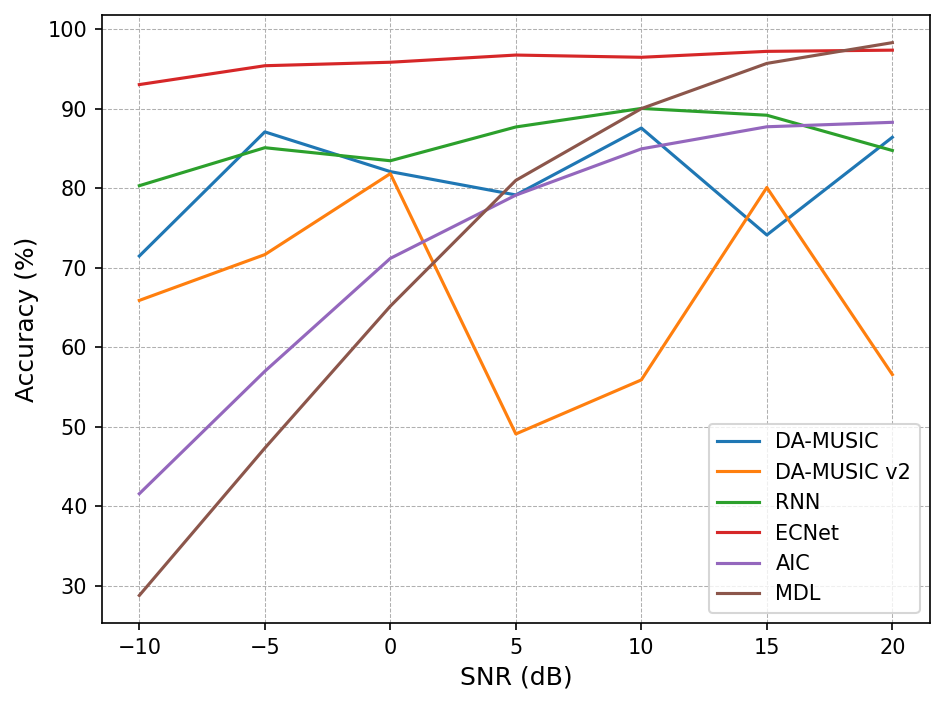

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

for i, method in enumerate(methods):
    plt.plot(SNRs, [x * 100 for x in accuracy[method]], label=method)

# plt.yscale("log")
plt.xlabel("SNR (dB)", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xticks(SNRs)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()